<a href="https://colab.research.google.com/github/maskmo/yield-and-transfer-learning/blob/main/Yield_Assignment_1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0
Found GPU at: /device:GPU:0


45 berries simulated


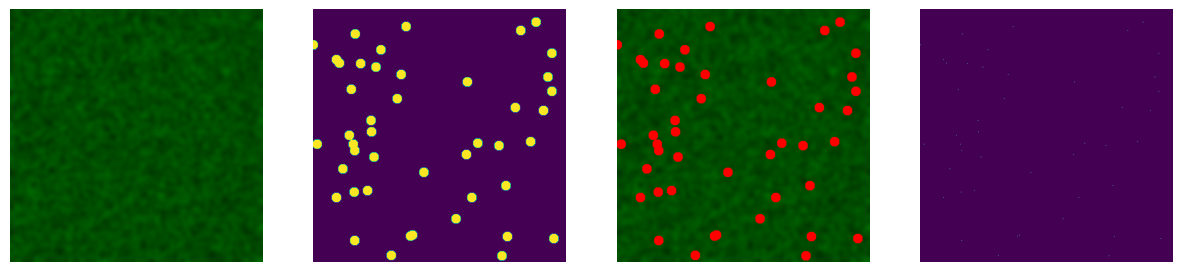

In [8]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw

FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 32
PATCH_HEIGHT = 32
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

def generate_image(with_intermediates=False):
  # the image has a random greenish background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1 ] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 25 and 75 berries randomly placed
  num_berries = np.random.randint(25, 75)
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  label[berry_cx, berry_cy] = 1

  # draw the berries which are 10 px in radius
  berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(berry_cx)):
    rr, cc = draw.disk(center = (berry_cx[idx], berry_cy[idx]),
                         radius=10,
                         shape=berries.shape)
    berries[rr, cc] = 1

  # add berries to the background
  img = np.copy(backgr)
  img[berries > 0] = [1, 0, 0] # red

  if with_intermediates:
    print("{} berries simulated".format(num_berries))
    return backgr, berries, img, label
  else:
    return img, label

images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
  ax[idx].imshow(img)
  ax[idx].axis('off')

In [10]:
## given an image, get the patches
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img,
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

In [11]:
# Getting input data
def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      # print(len(patches) * num_full_images)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))
  )

trainds = create_dataset(1) # will create 256 patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in image
  print(img.shape, label.numpy(), avg.numpy())

(12288,) 0.0 0.05320597
(12288,) 0.0 0.08963203
(12288,) 0.0 0.0914531


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 64)       

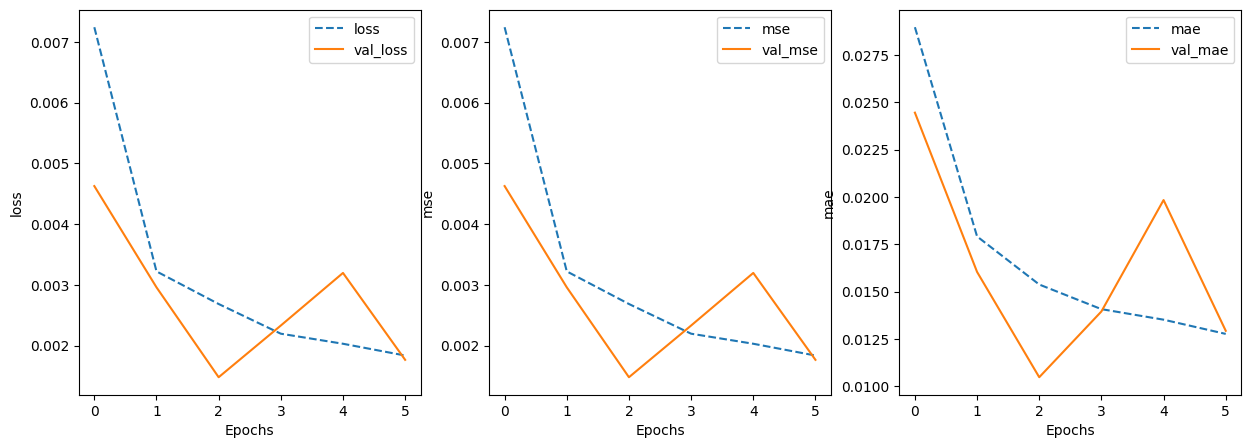

In [24]:
# Train
NUM_TRAIN = 500 # 10000 more realistic
NUM_EVAL = 20 # 1000 more realistic
NUM_EPOCHS = 5

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # a simple convnet. you can make it more complex, of course
  # the patch is flattened, so we start by reshaping to an image
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer,
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()


67 berries simulated
8/8 [==============================] - 0s 3ms/step
55 berries simulated
8/8 [==============================] - 0s 3ms/step
35 berries simulated
8/8 [==============================] - 0s 4ms/step
45 berries simulated
8/8 [==============================] - 0s 4ms/step
33 berries simulated
8/8 [==============================] - 0s 3ms/step
69 berries simulated
8/8 [==============================] - 0s 3ms/step
43 berries simulated
8/8 [==============================] - 0s 3ms/step
59 berries simulated
8/8 [==============================] - 0s 3ms/step
57 berries simulated
8/8 [==============================] - 0s 3ms/step
27 berries simulated
8/8 [==============================] - 0s 3ms/step
68 berries simulated
8/8 [==============================] - 0s 3ms/step
74 berries simulated
8/8 [==============================] - 0s 3ms/step
26 berries simulated
8/8 [==============================] - 0s 3ms/step
62 berries simulated
8/8 [==============================] - 0s 4

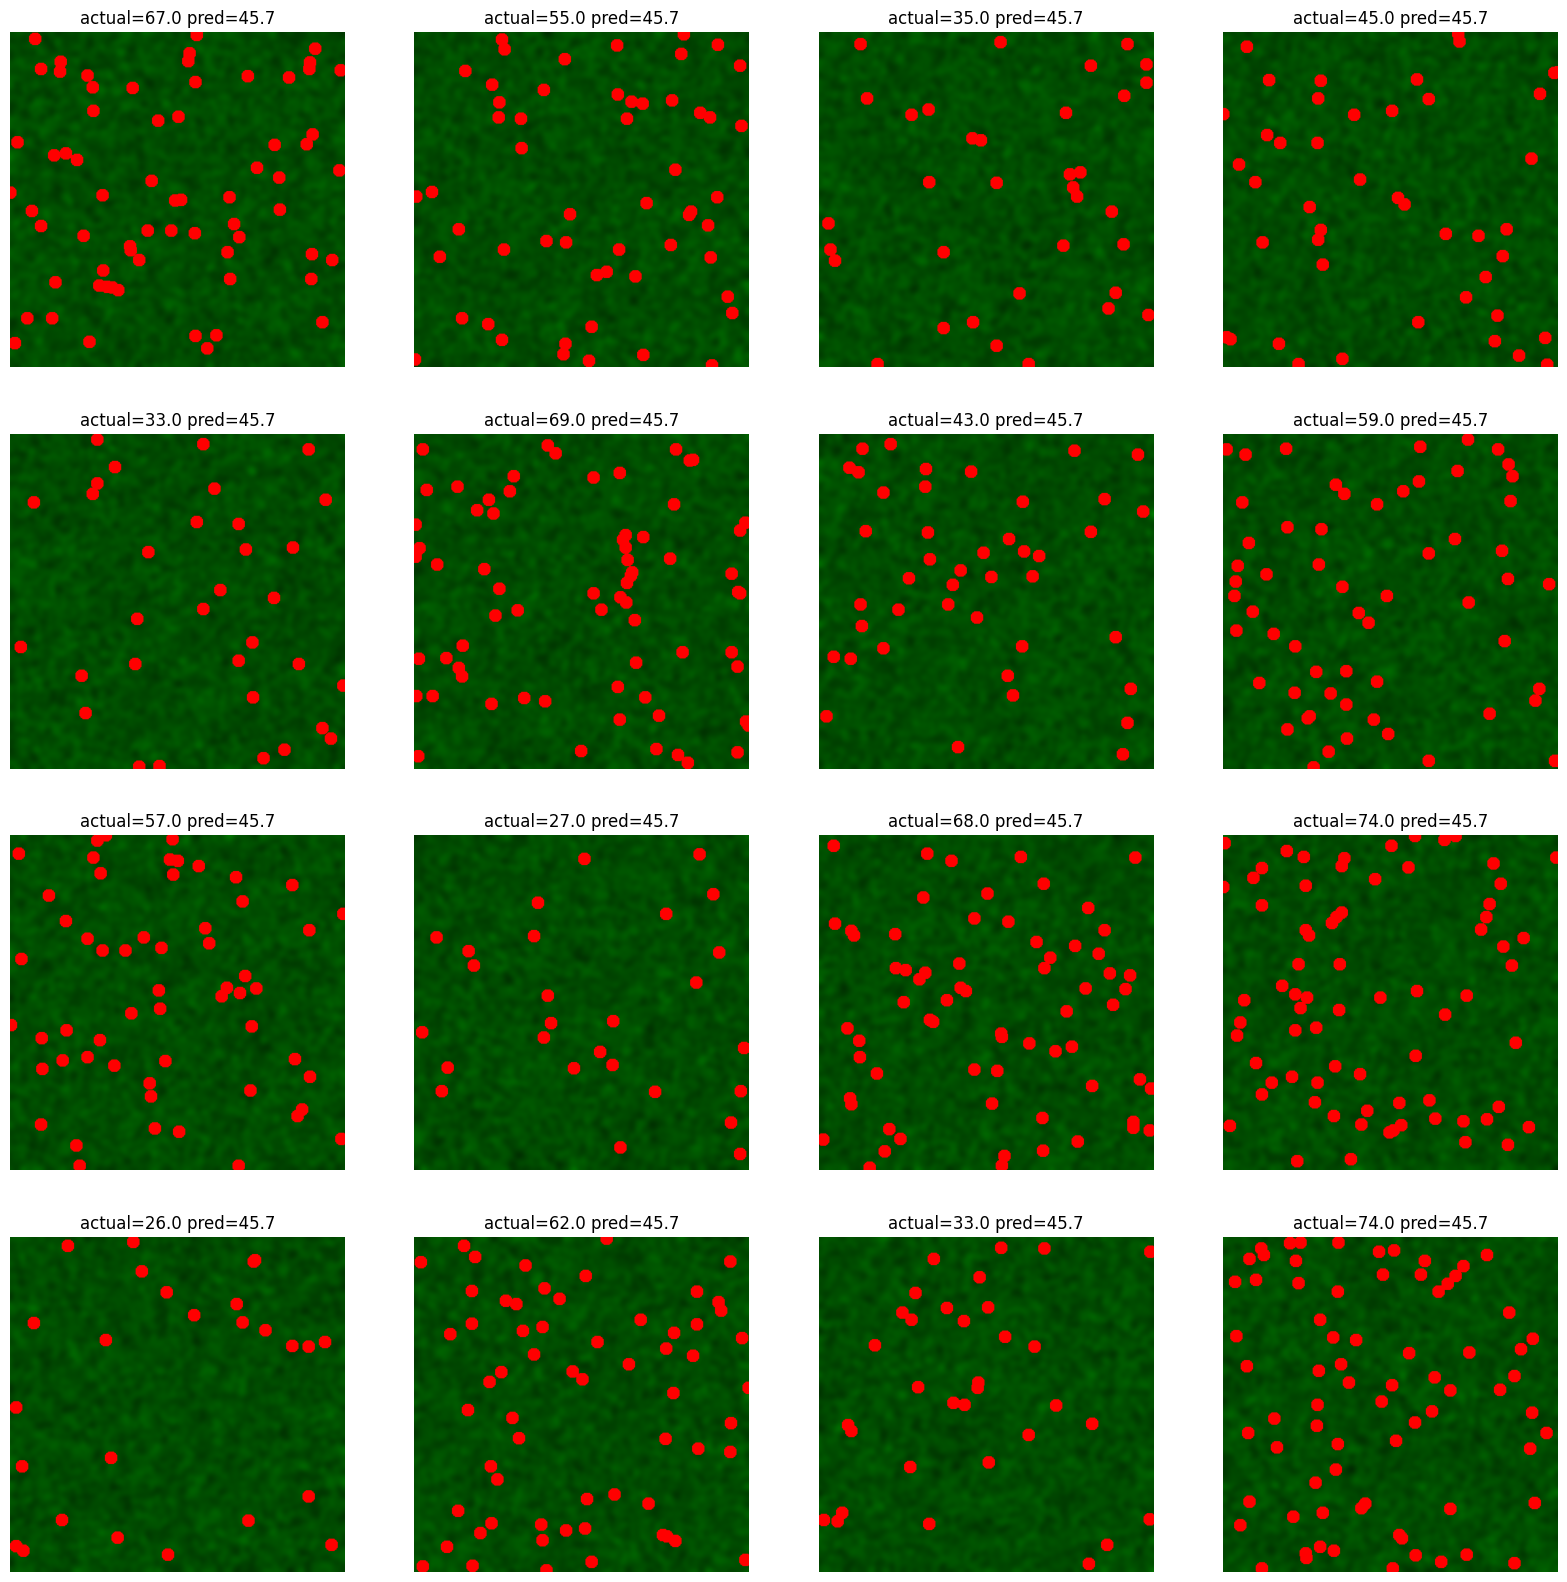

In [19]:
## prediction.
def count_berries(model, img):
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  img = tf.expand_dims(img, axis=0)
  patches = tf.image.extract_patches(img,
                sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                rates=[1, 1, 1, 1],
                padding='SAME',
                name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  densities = model.predict(patches)
  return tf.reduce_sum(densities)

# use an example image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  backgr, berries, img, label = generate_image(True)
  ax[idx//4, idx%4].imshow(img)
  ax[idx//4, idx%4].set_title("actual={:.1f} pred={:.1f}".format(
    tf.reduce_sum(label).numpy(),
    count_berries(model, img).numpy()
  ))
  ax[idx//4, idx%4].axis('off')

(1, 512, 512, 3) (1, 512, 512, 1)
(256, 12288) (256, 1024) (256,)


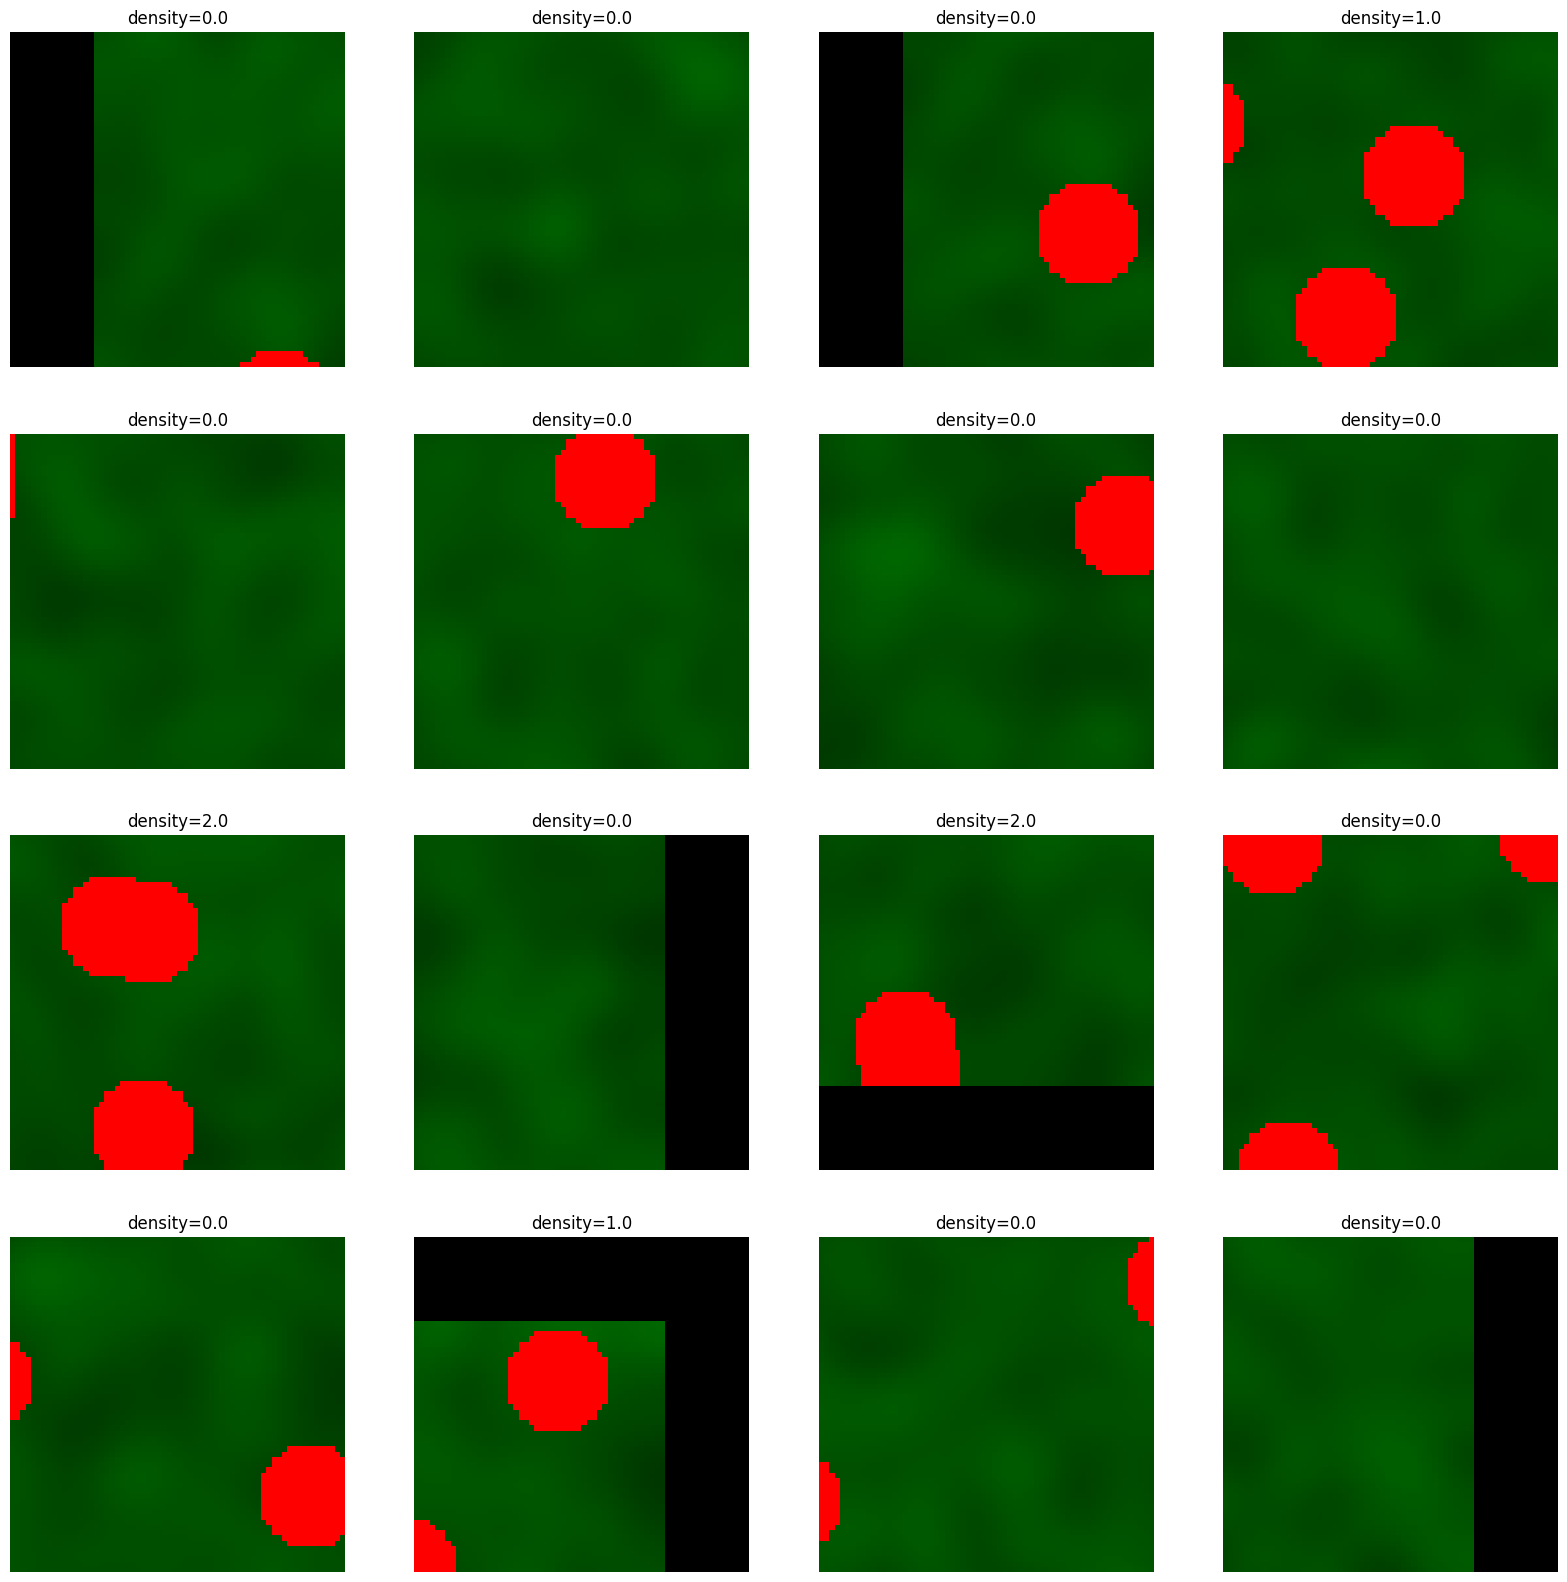

In [20]:
# OPTIONAL, CAN BE OMITTED
img, label = images = generate_image()
patches, labels = get_patches(img, label, verbose=True)

# display a few patches
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  r = np.random.randint(0, patches.shape[0])
  ax[idx//4, idx%4].imshow(tf.reshape(patches[r], [INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS]).numpy())
  ax[idx//4, idx%4].set_title("density={:.1f}".format(labels[r].numpy()))
  ax[idx//4, idx%4].axis('off')

In [25]:
contents = tf.io.read_file('/content/berries.jpeg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
n = count_berries(model, img)
print(n.numpy())

8/8 [==============================] - 0s 3ms/step
40.987347


Initial count = 1118.44 with (NUM_TRAIN = 200, NUM_EVAL = 10, NUM_EPOCHS = 5)
2nd count = 38.89 with (NUM_TRAIN = 1000, NUM_EVAL = 100, NUM_EPOCHS = 5)
3rd count = 40.98 with (NUM_TRAIN = 400, NUM_EVAL = 20, NUM_EPOCHS = 6)
Real count around 300.

It seems that the 2nd count had a stricter process for identifying baerries, possibly because the combination of having a higher number of epochs and double the ratio of evaluation data to training data meant overfitting to the synthetic data (the manufactured idea of what the berries look like as opposed to real photos of berries). Therefore, when run on real data the observation rate of berries was much lower. Although, since the real count is about 300 berries, the initial count is 3x the actual count, and the 2nd count is 1/3 the actual count which may be an interesting coincidence.

While running 15 epochs for the 2nd count I noticed a spike in error after 6 epochs, so I elected to tune the third count to 6 epochs, I also decreased the ration of evaluation data to training data to possibly avoid the error in the 2nd count. Although the benefit was small with an increase of 2 berries identified.